# Example of integrating a network

This notebook illustrates how to create a python network and integrate
it with the scipy library.

In [1]:
import pynucastro as pyna

We'll start again with the basic CNO network explored earlier.  Again, we'll read in the entire ReacLib library
and pass in the names of the rates in the form of a string `A(x,y)B` to filter out just the rates we are interested in.

In [2]:
rl = pyna.ReacLibLibrary()

In [3]:
rate_names = ["c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n14(p,g)o15",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15"]

rates = rl.get_rate_by_name(rate_names)
rates

[C12 + p ⟶ N13 + 𝛾,
 C13 + p ⟶ N14 + 𝛾,
 N13 ⟶ C13 + e⁺ + 𝜈,
 N13 + p ⟶ O14 + 𝛾,
 N14 + p ⟶ O15 + 𝛾,
 N15 + p ⟶ He4 + C12,
 O14 ⟶ N14 + e⁺ + 𝜈,
 O15 ⟶ N15 + e⁺ + 𝜈]

A `PythonNetwork` is based on a `RateCollection` but has methods to write the RHS of the system of ODEs.

In [4]:
pynet = pyna.PythonNetwork(rates=rates)

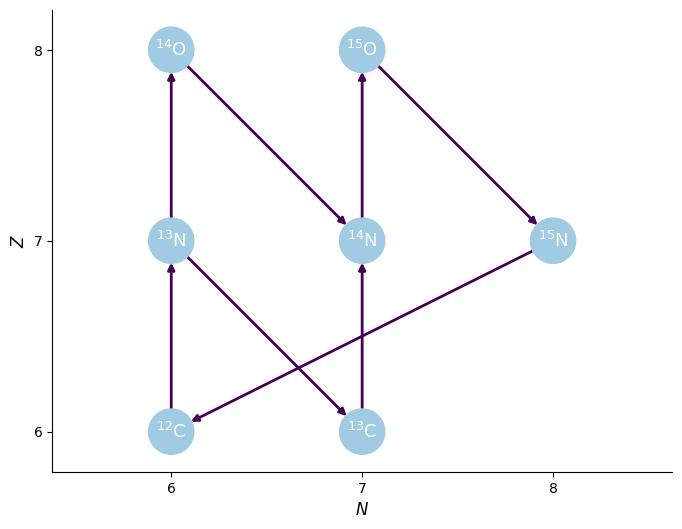

In [5]:
fig = pynet.plot()

For example, this network knows how to write the full term for a reaction that goes into the $dY/dt$ equation of the ODE system.

Here we pick one of the rates that is part of the network an explore it.

In [6]:
r = pynet.rates[1]
print(r)

C13 + p ⟶ N14 + 𝛾


a rate also knows what its contribution is to the $dY/dt$ equation is:

In [7]:
print(r.ydot_string_py())

rho*Y[jp]*Y[jc13]*rate_eval.p_C13__N14


and the code needed to evaluate that rate (the T-dependent part) is output by the `Rate` class::

In [8]:
print(r.function_string_py())

@numba.njit()
def p_C13__N14(rate_eval, tf):
    # C13 + p --> N14
    rate = 0.0

    # nacrr
    rate += np.exp(  15.1825 + -13.5543*tf.T9i
                  + -1.5*tf.lnT9)
    # nacrn
    rate += np.exp(  18.5155 + -13.72*tf.T913i + -0.450018*tf.T913
                  + 3.70823*tf.T9 + -1.70545*tf.T953 + -0.666667*tf.lnT9)
    # nacrr
    rate += np.exp(  13.9637 + -5.78147*tf.T9i + -0.196703*tf.T913
                  + 0.142126*tf.T9 + -0.0238912*tf.T953 + -1.5*tf.lnT9)

    rate_eval.p_C13__N14 = rate




The temperature-dependent rate evaluation functions take a `Tfactor` object, which precomputes most of the commonly-used temperature factors in the rates.

The `write_network()` method will output the python code needed to define the RHS of a network for integration with the SciPy integrators.

Since python code can be slow, we use Numba to do just-in-time compilation of the functions to speed things up.

In [9]:
pynet.write_network("cno_test_integrate.py")

In [10]:
%cat cno_test_integrate.py

import numba
import numpy as np
from numba.experimental import jitclass

from pynucastro.rates import TableIndex, TableInterpolator, TabularRate, Tfactors
from pynucastro.screening import PlasmaState, ScreenFactors

jp = 0
jhe4 = 1
jc12 = 2
jc13 = 3
jn13 = 4
jn14 = 5
jn15 = 6
jo14 = 7
jo15 = 8
nnuc = 9

A = np.zeros((nnuc), dtype=np.int32)

A[jp] = 1
A[jhe4] = 4
A[jc12] = 12
A[jc13] = 13
A[jn13] = 13
A[jn14] = 14
A[jn15] = 15
A[jo14] = 14
A[jo15] = 15

Z = np.zeros((nnuc), dtype=np.int32)

Z[jp] = 1
Z[jhe4] = 2
Z[jc12] = 6
Z[jc13] = 6
Z[jn13] = 7
Z[jn14] = 7
Z[jn15] = 7
Z[jo14] = 8
Z[jo15] = 8

names = []
names.append("H1")
names.append("He4")
names.append("C12")
names.append("C13")
names.append("N13")
names.append("N14")
names.append("N15")
names.append("O14")
names.append("O15")

def to_composition(Y):
    """Convert an array of molar fractions to a Composition object."""
    from pynucastro import Composition, Nucleus
    nuclei = [Nucleus.from_cache(name) for name in names]
    com

We can now import the network that was just created and integrate it using the SciPy ODE solvers

In [11]:
import cno_test_integrate as cno

## Integrating the network

We can use the stiff ODE integration solvers that are part of SciPy to integrate this system now

In [12]:
from scipy.integrate import solve_ivp
import numpy as np

Initialize the thermodynamic conditions and initial composition.  We express the composition as molar fractions, `Y0`.

In [13]:
rho = 150
T = 1.5e7

X0 = np.zeros(cno.nnuc)
X0[cno.jp] = 0.7
X0[cno.jhe4] = 0.28
X0[cno.jc12] = 0.02

Y0 = X0/cno.A

Now we integrate.  We use the `BDF` method, since reaction networks are in general stiff

In [14]:
tmax = 1.e20

sol = solve_ivp(cno.rhs, [0, tmax], Y0, method="BDF", jac=cno.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-6)

## Plotting the results

In [15]:
import matplotlib.pyplot as plt

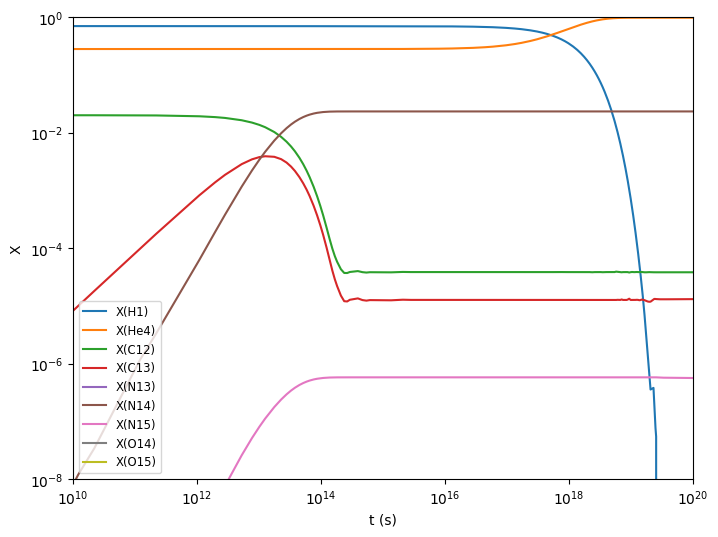

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(cno.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * cno.A[i], label=f"X({cno.names[i].capitalize()})")

ax.set_xlim(1.e10, 1.e20)
ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))